In [1]:
from PIL import Image
import numpy as np
import albumentations as A
from pathlib import Path

In [2]:
# instalar API de Kaggle y crear directorio y archivo para configurarla
!pip install --user kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import json

# completar con su información de usuario de Kaggle
api_token = {"username": "pedrolucasbarrera", "key": "6fb6bc323d0a19e6de629855b120ec60"}

with open('/root/.kaggle/kaggle.json','w') as file:
    json.dump(api_token,file)

!chmod 600 ~/.kaggle/kaggle.json

/bin/bash: chmod 600 ~/.kaggle/kaggle.json: No such file or directory


In [ ]:
# descargar y descomprimir dataset
!kaggle datasets download -d vbookshelf/pneumothorax-chest-xray-images-and-masks
!unzip pneumothorax-chest-xray-images-and-masks.zip

In [5]:
# definir las transformaciones para aumentación de datos
'''

Transformaciones disponibles:
https://github.com/albumentations-team/albumentations#pixel-level-transforms

ejemplo de transformación compuesta:

transform = A.Compose([
    A.RandomRotate90(),
    A.Transpose()
])

'''
transform = False

In [67]:
import tensorflow as tf
import random
 
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, path, img_prefix, mask_prefix, transform=False, batch_size=4, dim=(128,128), train=True, val = False,n_channels=1, shuffle=True):
        'Initialization'
        self.path = path
        self.transform = transform
        self.n_channels = n_channels
        self.img_prefix = img_prefix
        self.mask_prefix = mask_prefix
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        if train:
            files = [file.name for file in Path(path).glob("png_images/*train*1_.png")]
            self.filenames = files[0:(int(len(files)/100*90))]
            random.seed(4)
            random.shuffle(self.filenames)
        elif val:
            files = [file.name for file in Path(path).glob("png_images/*train*1_.png")]
            self.filenames = files[(int(len(files)/100*90)):]
            random.seed(4)
            np.random.shuffle(self.filenames)

        else:
            self.filenames = [file.name for file in Path(path).glob("png_images/*test*1_.png")]
            random.seed(4)
            np.random.shuffle(self.filenames)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(filenames)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.filenames)

    def __data_generation(self, filenames):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, filename in enumerate(filenames):
            img = Image.open(self.path + self.img_prefix + filename).resize(self.dim)
            mask = Image.open(self.path + self.mask_prefix + filename).resize(self.dim)
            if self.transform:
                trf = self.transform(image = np.array(img), mask = np.array(mask))
                X[i,...] = trf['image'].reshape(*self.dim, self.n_channels)/255.
                y[i,...] = trf['mask'].reshape(*self.dim, self.n_channels)/255.
            else:
                X[i,...] = np.array(img).reshape(*self.dim, self.n_channels)/255.
                y[i,...] = np.array(mask).reshape(*self.dim, self.n_channels)/255.
        return X,y

In [22]:
# tener cuidado con la selección del tamaño del batch. Al iniciar el entrenamiento
# dependiendo del tamaño de la red y el tamaño del batch, puede surgir un error OOM
# (out of memory) debido a las limitaciones de RAM de la GPU.
# En tal caso se deberá achicar el tamaño del batch

In [35]:
def datagen(batch, train, val, transformm = False):
  datagen_val = DataGenerator(
      'siim-acr-pneumothorax/',
      "png_images/",
      "png_masks/",
      transform = transformm,
      batch_size = batch,
      train = train,
      val = val
      )
  return datagen_val

In [9]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Dropout, Concatenate, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import backend as K

In [10]:
# definición del coeficiente de Dice
def dice_coef(y_true, y_pred, smooth=1.0):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

# función de costo que combina binary crossentropy con Dice
def dice_coef_loss(y_true, y_pred):
    dice_term = 1 - dice_coef(y_true, y_pred)
    bce = tf.keras.losses.BinaryCrossentropy()
    loss = dice_term * 0.5 + bce(y_true, y_pred)*0.5
    return loss

In [11]:
# definición de bloques para armar la arquitectura de UNet

def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', 
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

In [19]:
import matplotlib.pyplot as plt


In [49]:
def Plot_loss(history): 
  plt.plot(history.history["loss"],label="Train")
  plt.plot(history.history["val_loss"],label="Val")
  plt.title("loss")
  plt.legend()
  plt.show()

  plt.plot(history.history["binary_crossentropy"],label="Train")
  plt.plot(history.history["val_binary_crossentropy"],label="Val")

  plt.title("binary_crossentropy")
  plt.legend()
  plt.show()

  plt.plot(history.history["dice_coef"],label="Train")
  plt.plot(history.history["val_dice_coef"],label="Val")

  plt.title("dice_coef")
  plt.legend()
  plt.show()

In [52]:
def graficar_pred(data, pred):
  for idx in range(4):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(data[0][0][idx].reshape(128,128))
    ax1.set_title(f'Imagen {idx+1}')
    ax2.imshow(data[0][1][idx].reshape(128,128))
    ax2.set_title(f'Mask {idx+1}')
    ax3.imshow(pred[idx].reshape(128,128))
    ax3.set_title(f'Predicción {idx+1}')

##Modelo 1

En esta ocasión se entrenó una UNET con los siguientes parametros:
- Profundidad = 5
- Batchnormalization = False
- Batchsize = 64 
- Cantidad de imagenes de Train = 90% de las de train
- Cantidad de imagenes de Val = 10% de las de train
- Cantidad de imagenes de Test = Todas
- Epochs = 10
- DataAugmentation = No

In [103]:
batch = 64
batchnorm = False
depth = 5
dropout = False
epochs = 20

In [104]:
datagen_train_1 = datagen(batch = batch, train = True , val = False, transformm = False)
datagen_val_1 = datagen(batch = batch, train = False , val = True, transformm = False)
datagen_test_1 = datagen(batch = batch, train = False , val = False, transformm = False)

In [105]:
# instanciación del modelo
model1 = UNet((128,128,1),start_ch=32,depth=depth,batchnorm=batchnorm, residual = True,dropout=dropout)
# compilación
model1.compile(loss=dice_coef_loss, optimizer="adam", metrics=["binary_crossentropy", dice_coef])

In [106]:
history1 = model1.fit(datagen_train_1, epochs = 10, validation_data=datagen_val_1)

Epoch 1/10
33/33 [==============================] - 60s 2s/step - loss: 0.8332 - binary_crossentropy: 0.6864 - dice_coef: 0.0200 - val_loss: 0.5166 - val_binary_crossentropy: 0.0686 - val_dice_coef: 0.0355
Epoch 2/10
33/33 [==============================] - 56s 2s/step - loss: 0.4946 - binary_crossentropy: 0.0744 - dice_coef: 0.0852 - val_loss: 0.4826 - val_binary_crossentropy: 0.0942 - val_dice_coef: 0.1291
Epoch 3/10
33/33 [==============================] - 57s 2s/step - loss: 0.4656 - binary_crossentropy: 0.0843 - dice_coef: 0.1530 - val_loss: 0.4577 - val_binary_crossentropy: 0.0944 - val_dice_coef: 0.1791
Epoch 4/10
33/33 [==============================] - 56s 2s/step - loss: 0.4448 - binary_crossentropy: 0.0832 - dice_coef: 0.1937 - val_loss: 0.4464 - val_binary_crossentropy: 0.0831 - val_dice_coef: 0.1902
Epoch 5/10
33/33 [==============================] - 56s 2s/step - loss: 0.4220 - binary_crossentropy: 0.0809 - dice_coef: 0.2369 - val_loss: 0.4104 - val_binary_crossentropy: 0

In [107]:
preds_train1 = model1.predict(datagen_train_1)
preds_test1 = model1.predict(datagen_test_1)

4/4 [==============================] - 5s 1s/step


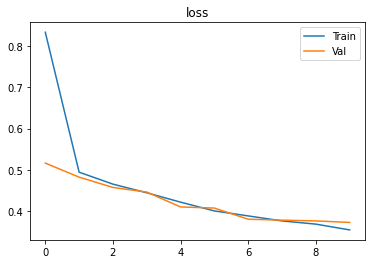

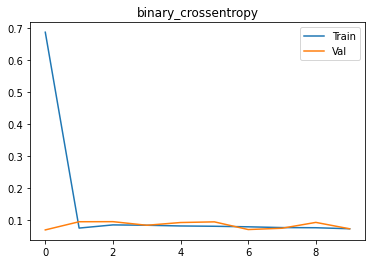

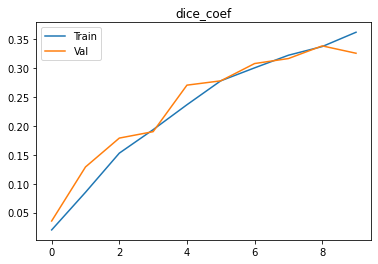

In [108]:
Plot_loss(history1)

TRAIN
TEST


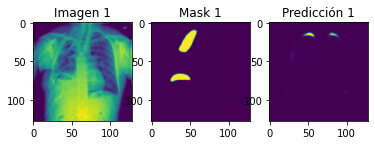

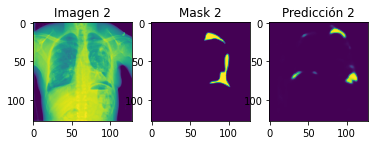

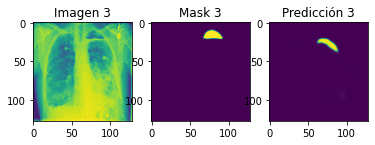

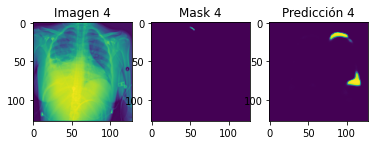

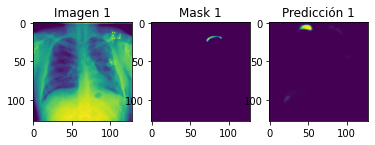

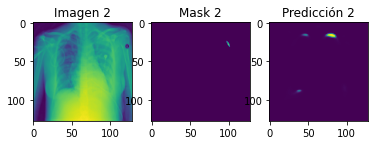

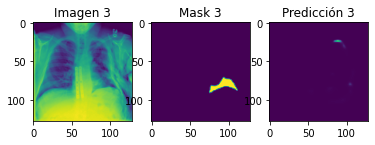

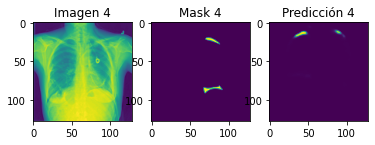

In [109]:
print("TRAIN")
graficar_pred(datagen_train_1,preds_train1)
print("TEST")
graficar_pred(datagen_test_1,preds_test1)

In [110]:
model1.evaluate(datagen_test_1)

4/4 [==============================] - 6s 1s/step - loss: 0.3780 - binary_crossentropy: 0.0710 - dice_coef: 0.3149


[0.37804707884788513, 0.07098247110843658, 0.3148882985115051]

Se ve que el modelo tiene capacidad de aumentar el overfitting al aumentar los epochs.

##Modelo 2

En esta ocasión se entrenó una UNET con los siguientes parametros:
- Profundidad = 3
- Batchnormalization = False
- Batchsize = 128 
- Cantidad de imagenes de Train = 90% de las de train
- Cantidad de imagenes de Val = 10% de las de train
- Cantidad de imagenes de Test = Todas
- Epochs = 20
- DataAugmentation = No

Se eligió profundidad de 3 porque al elegir 5 tiraba el error "Graph error" y no me dejaba continuar.

In [94]:
batch = 128
batchnorm = False
depth = 3
dropout = False
epochs = 20

In [97]:
datagen_train_2 = datagen(batch = batch, train = True , val = False, transformm = False)
datagen_val_2 = datagen(batch = batch, train = False , val = True, transformm = False)
datagen_test_2 = datagen(batch = batch, train = False , val = False, transformm = False)

In [98]:
# instanciación del modelo
model2 = UNet((128,128,1),start_ch=32,depth=depth,batchnorm=batchnorm, residual = True,dropout=dropout)
# compilación
model2.compile(loss=dice_coef_loss, optimizer="adam", metrics=["binary_crossentropy", dice_coef])

In [99]:
history2 = model2.fit(datagen_train_2, epochs = epochs, validation_data=datagen_val_2)

Epoch 1/20
16/16 [==============================] - 58s 3s/step - loss: 0.5951 - binary_crossentropy: 0.2019 - dice_coef: 0.0117 - val_loss: 0.5312 - val_binary_crossentropy: 0.0758 - val_dice_coef: 0.0134
Epoch 2/20
16/16 [==============================] - 51s 3s/step - loss: 0.5208 - binary_crossentropy: 0.0718 - dice_coef: 0.0301 - val_loss: 0.5140 - val_binary_crossentropy: 0.0652 - val_dice_coef: 0.0372
Epoch 3/20
16/16 [==============================] - 52s 3s/step - loss: 0.5062 - binary_crossentropy: 0.0736 - dice_coef: 0.0612 - val_loss: 0.5026 - val_binary_crossentropy: 0.0735 - val_dice_coef: 0.0683
Epoch 4/20
16/16 [==============================] - 52s 3s/step - loss: 0.4930 - binary_crossentropy: 0.0807 - dice_coef: 0.0946 - val_loss: 0.4963 - val_binary_crossentropy: 0.0789 - val_dice_coef: 0.0863
Epoch 5/20
16/16 [==============================] - 51s 3s/step - loss: 0.4824 - binary_crossentropy: 0.0809 - dice_coef: 0.1160 - val_loss: 0.4710 - val_binary_crossentropy: 0

In [100]:
preds_train2 = model2.predict(datagen_train_2)
preds_test2 = model2.predict(datagen_test_2)

2/2 [==============================] - 5s 3s/step


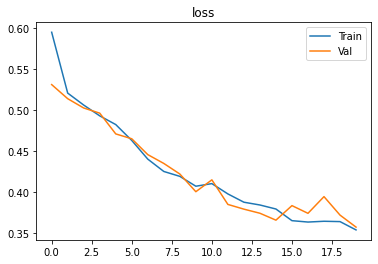

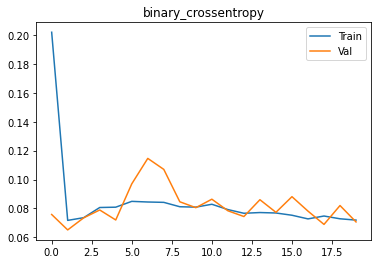

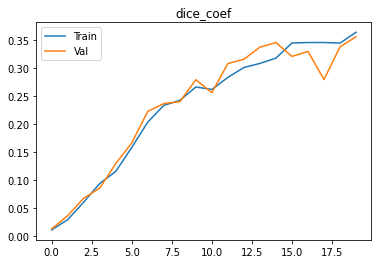

In [101]:
Plot_loss(history2)

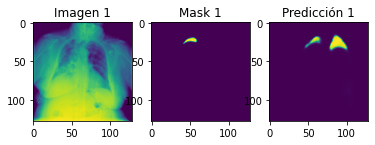

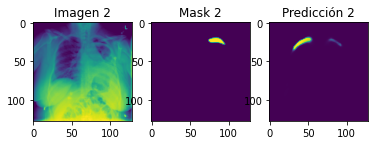

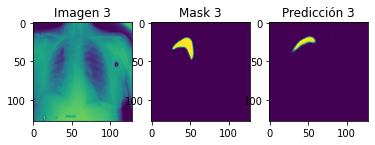

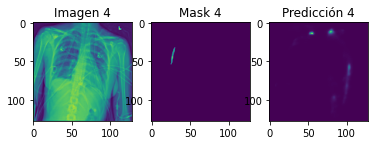

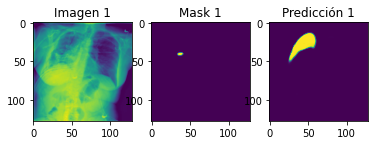

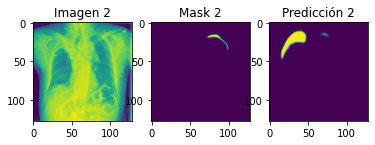

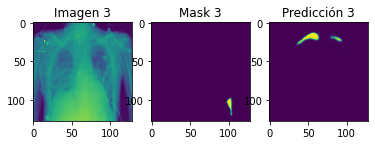

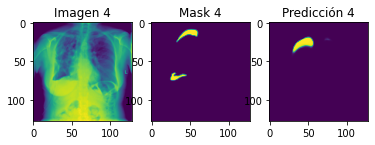

In [55]:
print("TRAIN")
graficar_pred(datagen_train_2,preds_train2)
print("TEST")
graficar_pred(datagen_test_2,preds_test2)

In [102]:
model2.evaluate(datagen_test_2)

2/2 [==============================] - 6s 3s/step - loss: 0.3723 - binary_crossentropy: 0.0724 - dice_coef: 0.3278


[0.3722940683364868, 0.07235215604305267, 0.32776397466659546]

Se consiguio un coeficiente de dice de test y coeficientedes de dice y loss de tanto validadion como train muy similares al caso con 64 de batch size. Pareciera por los graficos de dice y de loss que el sistema tiene aun capacidad para overfitting si se aumentaran los epochs.

##Modelo 3

En esta ocasión se entrenó una UNET con los mismos parametros que el anterior pero usando batchnormalization ,dado que se posee un bathsize lo suficientemente grande(128).


In [78]:
batch = 128
batchnorm = True
depth = 3
dropout = False
epochs = 20

In [79]:
datagen_train_3 = datagen(batch = batch, train = True , val = False, transformm = False)
datagen_val_3 = datagen(batch = batch, train = False , val = True, transformm = False)
datagen_test_3 = datagen(batch = batch, train = False , val = False, transformm = False)

In [80]:
# instanciación del modelo
model3 = UNet((128,128,1),start_ch=32,depth=depth,batchnorm=batchnorm, residual = True,dropout=dropout)
# compilación
model3.compile(loss=dice_coef_loss, optimizer="adam", metrics=["binary_crossentropy", dice_coef])

In [81]:
history3 = model3.fit(datagen_train_3, epochs = epochs, validation_data=datagen_val_3)

Epoch 1/20
16/16 [==============================] - 158s 4s/step - loss: 0.5015 - binary_crossentropy: 0.1486 - dice_coef: 0.1455 - val_loss: 0.6676 - val_binary_crossentropy: 0.3617 - val_dice_coef: 0.0265
Epoch 2/20
16/16 [==============================] - 54s 3s/step - loss: 0.3982 - binary_crossentropy: 0.0799 - dice_coef: 0.2835 - val_loss: 0.5681 - val_binary_crossentropy: 0.1611 - val_dice_coef: 0.0249
Epoch 3/20
16/16 [==============================] - 55s 3s/step - loss: 0.3806 - binary_crossentropy: 0.0780 - dice_coef: 0.3168 - val_loss: 0.5487 - val_binary_crossentropy: 0.1168 - val_dice_coef: 0.0194
Epoch 4/20
16/16 [==============================] - 58s 4s/step - loss: 0.3626 - binary_crossentropy: 0.0741 - dice_coef: 0.3490 - val_loss: 0.5389 - val_binary_crossentropy: 0.0956 - val_dice_coef: 0.0178
Epoch 5/20
16/16 [==============================] - 63s 4s/step - loss: 0.3513 - binary_crossentropy: 0.0722 - dice_coef: 0.3697 - val_loss: 0.5440 - val_binary_crossentropy: 

In [82]:
preds_train3 = model3.predict(datagen_train_3)
preds_test3 = model3.predict(datagen_test_3)

2/2 [==============================] - 7s 4s/step


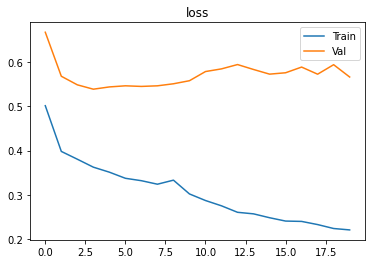

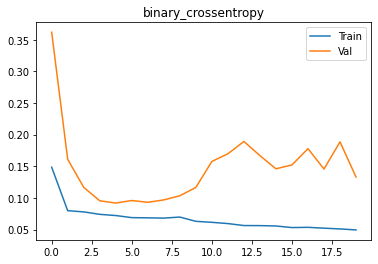

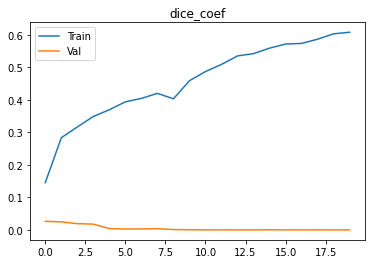

In [83]:
Plot_loss(history3)

TRAIN
TEST


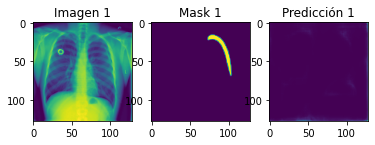

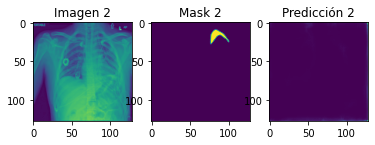

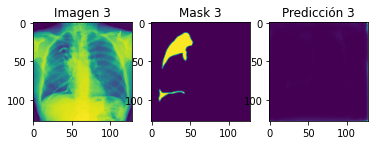

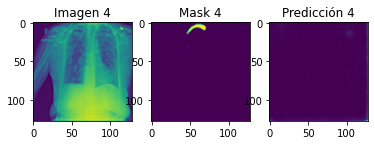

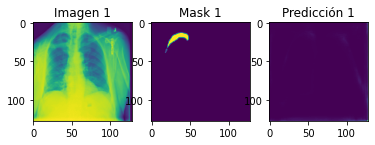

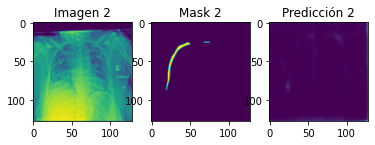

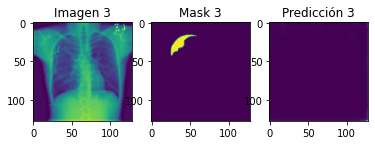

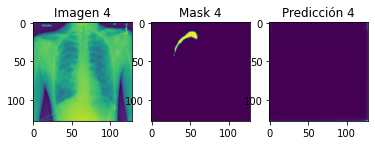

In [84]:
print("TRAIN")
graficar_pred(datagen_train_3,preds_train3)
print("TEST")
graficar_pred(datagen_test_3,preds_test3)

In [85]:
model3.evaluate(datagen_test_3)

2/2 [==============================] - 6s 3s/step - loss: 0.5681 - binary_crossentropy: 0.1364 - dice_coef: 2.2797e-04


[0.568083643913269, 0.13639527559280396, 0.00022797084238845855]

Puede verse que al usar batchnormalization no se consiguió una gran aceleración del training (tardó casi lo mismo) y se consiguieron mucho peores resutlados (dice cercano a 0 en train, muy malo) para test, ademas de no lograrse mucho mejores resultados para test tampoco, por lo que no pareceiera ser útil batchnormalization con batch size de 128, talvez debería usarse uno aun más grande. Pareciera demas, este modelo fue especialmente malo para clasificar imagenes que no fueran de su entrenamiento, como puede verse en el grafico del dice del conjunto de validación.

En las predicciones graficas, puede verse como pareciera que no predició para ninguna imagen nada (incluido test, que es raro dado que el dice no es tan bajo). Esto, sumado al extremadamente bajo valor de val_dice y de test_dice, además del hecho de que el dice de train no es tan bajo pero aun asi pareciera no hacer ninguna predicción correctamente indica que podría haber algun error.

##Modelo 4

En esta ocasión se entrenó una UNET con los mismos parametros que el anterior pero realizando una transformacion de datos y sin batchnormalization


In [86]:
batch = 128
batchnorm = False
depth = 3
dropout = False
epochs = 20
transform = A.Compose([
    A. ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    A.RandomBrightnessContrast()
])

In [87]:
datagen_train_4 = datagen(batch = batch, train = True , val = False, transformm = transform)
datagen_val_4 = datagen(batch = batch, train = False , val = True, transformm = False)
datagen_test_4 = datagen(batch = batch, train = False , val = False, transformm = False)

In [88]:
# instanciación del modelo
model4 = UNet((128,128,1),start_ch=32,depth=depth,batchnorm=batchnorm, residual = True,dropout=dropout)
# compilación
model4.compile(loss=dice_coef_loss, optimizer="adam", metrics=["binary_crossentropy", dice_coef])

In [89]:
history4 = model4.fit(datagen_train_4, epochs = epochs, validation_data=datagen_val_4)

Epoch 1/20
16/16 [==============================] - 58s 3s/step - loss: 0.5932 - binary_crossentropy: 0.1982 - dice_coef: 0.0118 - val_loss: 0.5347 - val_binary_crossentropy: 0.0871 - val_dice_coef: 0.0177
Epoch 2/20
16/16 [==============================] - 54s 3s/step - loss: 0.5229 - binary_crossentropy: 0.0732 - dice_coef: 0.0275 - val_loss: 0.5187 - val_binary_crossentropy: 0.0713 - val_dice_coef: 0.0339
Epoch 3/20
16/16 [==============================] - 56s 3s/step - loss: 0.5117 - binary_crossentropy: 0.0692 - dice_coef: 0.0457 - val_loss: 0.5019 - val_binary_crossentropy: 0.0724 - val_dice_coef: 0.0686
Epoch 4/20
16/16 [==============================] - 59s 4s/step - loss: 0.4935 - binary_crossentropy: 0.0757 - dice_coef: 0.0887 - val_loss: 0.4985 - val_binary_crossentropy: 0.0893 - val_dice_coef: 0.0922
Epoch 5/20
16/16 [==============================] - 53s 3s/step - loss: 0.4835 - binary_crossentropy: 0.0839 - dice_coef: 0.1169 - val_loss: 0.4830 - val_binary_crossentropy: 0

In [90]:
preds_train4 = model4.predict(datagen_train_4)
preds_test4 = model4.predict(datagen_test_4)

2/2 [==============================] - 5s 3s/step


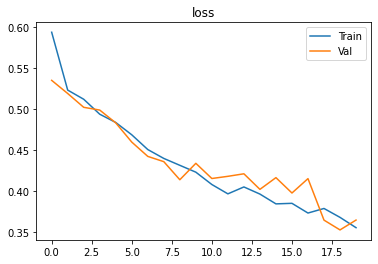

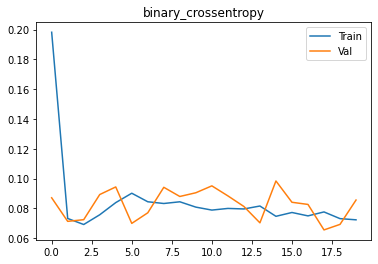

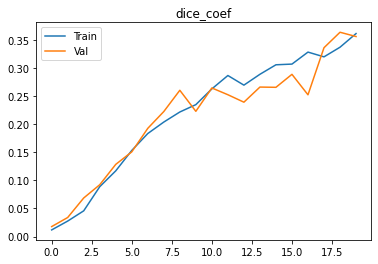

In [91]:
Plot_loss(history4)

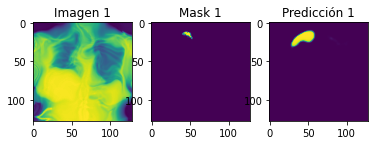

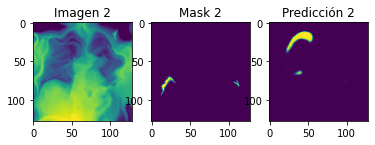

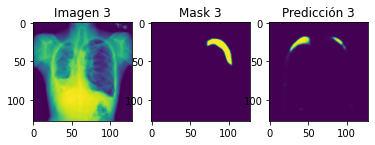

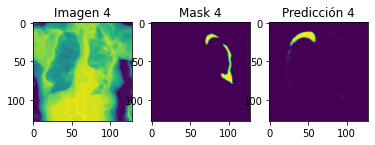

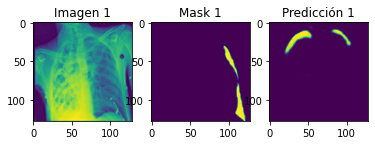

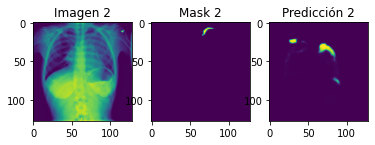

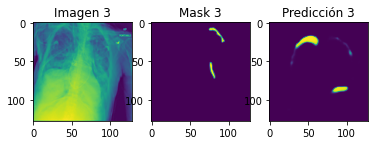

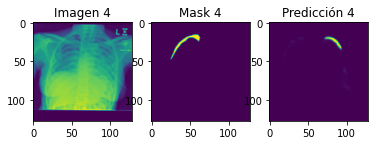

In [92]:

graficar_pred(datagen_train_4,preds_train4)

graficar_pred(datagen_test_4,preds_test4)

In [93]:
model4.evaluate(datagen_test_4)

2/2 [==============================] - 6s 3s/step - loss: 0.3822 - binary_crossentropy: 0.0889 - dice_coef: 0.3246


[0.3821530342102051, 0.08891692012548447, 0.3246108889579773]

Comparando con los parametros del modelo 2,pareciera que la transformación utilizada no generó una mejora en el modelo, dado que tanto el coeficiente de dice como la loss de test y de validación dieron similares para los modelos con y sin transformacion de datos. Cabe destacar que, tanto en este modelo como en el 2, pareciera que el sistema tiene mas capacidad de overfitting que podria ser alcanzado aumentando el numero de epochs.

### Modelo 5
En este modelo se entreno con los mismos parametros que el modelo 1, pero con 50 epochs para evaluar la capacidad de overfitting.

In [118]:
batch = 64
batchnorm = False
depth = 5
dropout = False
epochs = 50

In [119]:
datagen_train_5 = datagen(batch = batch, train = True , val = False, transformm = False)
datagen_val_5 = datagen(batch = batch, train = False , val = True, transformm = False)
datagen_test_5 = datagen(batch = batch, train = False , val = False, transformm = False)

In [120]:
# instanciación del modelo
model5 = UNet((128,128,1),start_ch=32,depth=depth,batchnorm=batchnorm, residual = True,dropout=dropout)
# compilación
model5.compile(loss=dice_coef_loss, optimizer="adam", metrics=["binary_crossentropy", dice_coef])

In [121]:
history5 = model5.fit(datagen_train_5, epochs = epochs, validation_data=datagen_val_5)

Epoch 1/50
33/33 [==============================] - 61s 2s/step - loss: 1.0347 - binary_crossentropy: 1.0882 - dice_coef: 0.0187 - val_loss: 0.5161 - val_binary_crossentropy: 0.0729 - val_dice_coef: 0.0406
Epoch 2/50
33/33 [==============================] - 56s 2s/step - loss: 0.4921 - binary_crossentropy: 0.0728 - dice_coef: 0.0885 - val_loss: 0.4931 - val_binary_crossentropy: 0.1029 - val_dice_coef: 0.1166
Epoch 3/50
33/33 [==============================] - 57s 2s/step - loss: 0.4674 - binary_crossentropy: 0.0868 - dice_coef: 0.1519 - val_loss: 0.4759 - val_binary_crossentropy: 0.0786 - val_dice_coef: 0.1267
Epoch 4/50
33/33 [==============================] - 56s 2s/step - loss: 0.4451 - binary_crossentropy: 0.0822 - dice_coef: 0.1921 - val_loss: 0.4567 - val_binary_crossentropy: 0.0981 - val_dice_coef: 0.1847
Epoch 5/50
33/33 [==============================] - 56s 2s/step - loss: 0.4259 - binary_crossentropy: 0.0824 - dice_coef: 0.2306 - val_loss: 0.4220 - val_binary_crossentropy: 0

In [122]:
preds_train5 = model5.predict(datagen_train_5)
preds_test5 = model5.predict(datagen_test_5)

4/4 [==============================] - 5s 1s/step


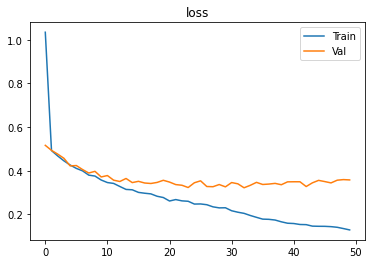

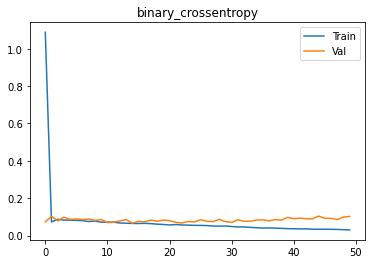

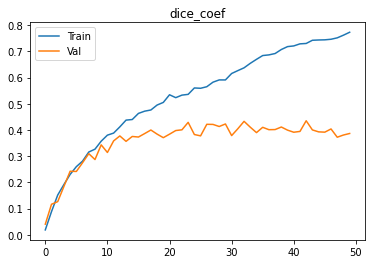

In [123]:
Plot_loss(history5)

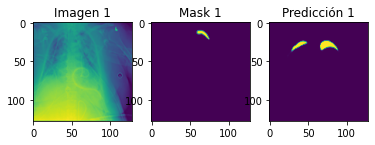

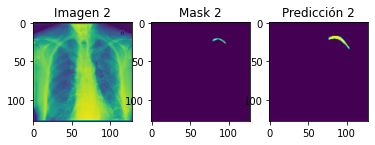

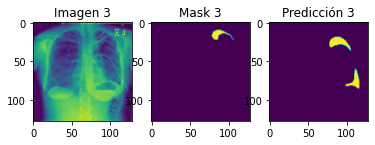

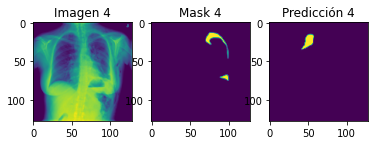

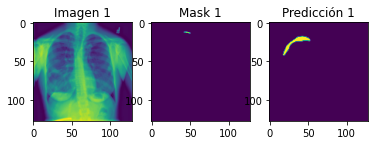

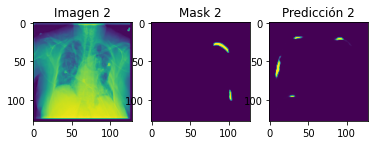

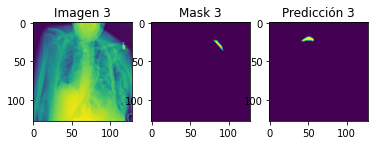

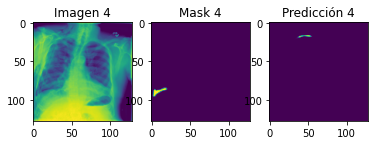

In [124]:

graficar_pred(datagen_train_5,preds_train5)

graficar_pred(datagen_test_5,preds_test5)

In [125]:
model5.evaluate(datagen_test_5)

4/4 [==============================] - 6s 1s/step - loss: 0.3310 - binary_crossentropy: 0.0863 - dice_coef: 0.4242


[0.33104005455970764, 0.08628172427415848, 0.424201637506485]

Como puede verse en el gráfico de dice y de loss de testeo vs validación, pareciera que aún habia mas espacio para el overfitteo del sistema con estos parametros, por lo que corriendo mas epochs podría conseguirse un dice para train muiy cercano aq uno, logrando un sistema  con un gran overfitting. A partir de este modelo, deberían probarse distintos métodos de regularización (como l2 por ejemplo o dropout) para ver si se puede reducir el overfitting y lograr que el modelo se adapte tambien mejor a imagenes generales distintas a las del conjunto de testeo.
Puede evrse tambien que al aumentar los epochs no se lograrísa una mejora en la predicción en conjuntos distintos al de entrenamiento, viendo como el coeficiente de dice y la loss de validación se estancan luego de aproximadamente 20 epochs. Cabe destacar que aqui se consiguio el mejor dice para el conjunto de testeo, con 0.42

### MODELO 6

In [126]:
batch = 64
batchnorm = False
depth = 5
dropout = False
epochs = 20
transform =A.Compose([
    A.HorizontalFlip(p=0.5),
    A.OneOf([
        A.RandomContrast(),
        A.RandomGamma(),
        A.RandomBrightness(),
         ], p=0.3),
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(),
        A.OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.3)
],p=1)

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1641: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1615: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [127]:
datagen_train_6 = datagen(batch = batch, train = True , val = False, transformm = transform)
datagen_val_6 = datagen(batch = batch, train = False , val = True, transformm = False)
datagen_test_6 = datagen(batch = batch, train = False , val = False, transformm = False)

In [128]:
# instanciación del modelo
model6 = UNet((128,128,1),start_ch=32,depth=depth,batchnorm=batchnorm, residual = True,dropout=dropout)
# compilación
model6.compile(loss=dice_coef_loss, optimizer="adam", metrics=["binary_crossentropy", dice_coef])

In [129]:
history6 = model6.fit(datagen_train_6, epochs = epochs, validation_data=datagen_val_6)

Epoch 1/20
33/33 [==============================] - 63s 2s/step - loss: 0.6165 - binary_crossentropy: 0.2542 - dice_coef: 0.0212 - val_loss: 0.5156 - val_binary_crossentropy: 0.0770 - val_dice_coef: 0.0459
Epoch 2/20
33/33 [==============================] - 58s 2s/step - loss: 0.4938 - binary_crossentropy: 0.0801 - dice_coef: 0.0924 - val_loss: 0.5033 - val_binary_crossentropy: 0.0837 - val_dice_coef: 0.0771
Epoch 3/20
33/33 [==============================] - 59s 2s/step - loss: 0.4790 - binary_crossentropy: 0.0857 - dice_coef: 0.1276 - val_loss: 0.4636 - val_binary_crossentropy: 0.0871 - val_dice_coef: 0.1600
Epoch 4/20
33/33 [==============================] - 58s 2s/step - loss: 0.4634 - binary_crossentropy: 0.0878 - dice_coef: 0.1610 - val_loss: 0.4519 - val_binary_crossentropy: 0.0862 - val_dice_coef: 0.1825
Epoch 5/20
33/33 [==============================] - 58s 2s/step - loss: 0.4462 - binary_crossentropy: 0.0858 - dice_coef: 0.1935 - val_loss: 0.4386 - val_binary_crossentropy: 0

Sobre este ultimo modelo no se pudieron obtener mas resultados, dado que se desconectó en entorno de ejecución, por lo que se perdieron todas las variables y modelos entrenados y n ose disponía de mas uso de GPU de Google para continuar. De todos modos, puede verse un coeficiente de dice de validacion de 0.38 y de test de 0.349, por lo que la transformación no pareciera haber generado una gran mejora en el entrenamiento.